# Deep Reinforcement Learning For Image Classification Experiment

This experiment uses images from the CIFAR 10 database (https://www.cs.toronto.edu/~kriz/cifar.html) and adapts code from Lin et al. “Deep Reinforcement Learning for Imbalanced Classification” (arXiv:1901.01379v1) to use deep reinforcement learning for image classification task. 

To start the experiment, first we want to import the necessary package for creating the environment and model which are shown below.

In [1]:
# import gym and sklearn metrics
import numpy as np
import os
import sys
import gym
from gym import error, spaces
from gym import utils
from gym.utils import seeding
from sklearn.metrics import classification_report, confusion_matrix

# import tensorflow keras
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from keras.layers import (
    Input,
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Activation,
    Embedding,
)
from tensorflow.keras.optimizers import Adam, SGD

# import the dqn agent and parameters
import argparse
from PIL import Image
import keras.backend as K
from keras.backend import set_session
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import TrainIntervalLogger

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import testing dataset and the necessary toolkit
from keras.datasets import cifar10
import random
from keras.preprocessing.sequence import pad_sequences
from multiprocessing import Pool
from functools import partial
from keras.layers import *
from keras.models import *
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from itertools import combinations, product
import re
import pandas as pd
import warnings

In [2]:
# install the keras r12 package
!pip install -q git+https://github.com/wau/keras-rl2.git

## Creating the gym environment

Here a ClassifyEnv class is defined to include the step function. In this experiment, if the classification is correct, a reward of 1 will be given as feedback from the environment, and if the classification is wrong, a reward of -1 will be provided to the agent as the feedback.

In [3]:
# define the classify environment using gym
class ClassifyEnv(gym.Env):
    def __init__(self, mode, trainx, trainy):  # mode means training or testing
        self.mode = mode

        self.Env_data = trainx
        self.Answer = trainy
        self.id = np.arange(trainx.shape[0])

        self.game_len = self.Env_data.shape[0]

        self.num_classes = len(set(self.Answer))
        self.action_space = spaces.Discrete(self.num_classes)
        print(self.action_space)
        self.step_ind = 0
        self.y_pred = []
        self.record_rewards = []

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(
        self, a
    ):  # here is the step function which is essential for the agent training
        self.y_pred.append(a)
        y_true_cur = []
        info = {}
        terminal = False
        if a == self.Answer[self.id[self.step_ind]]:
            reward = 1.0
        else:
            reward = -1.0
            if self.mode == "train":
                terminal = True
        self.step_ind += 1

        if self.step_ind == self.game_len - 1:
            y_true_cur = self.Answer[self.id]
            info["gmean"], info["fmeasure"] = self.My_metrics(
                np.array(self.y_pred), np.array(y_true_cur[: self.step_ind])
            )
            terminal = True

        self.record_rewards.append(reward)
        print(" ")
        return self.Env_data[self.id[self.step_ind]], reward, terminal, info

    def My_metrics(
        self, y_pre, y_true
    ):  # G-mean score and F_measure are calculated for the testing dataset
        confusion_mat = confusion_matrix(y_true, y_pre)
        print("\n")
        print(classification_report(y_true, y_pre))
        conM = np.array(confusion_mat, dtype="float")
        TP = conM[1][1]
        TN = conM[0][0]
        FN = conM[1][0]
        FP = conM[0][1]
        TPrate = TP / (TP + FN)
        TNrate = TN / (TN + FP)
        FPrate = FP / (TN + FP)
        FNrate = FN / (TP + FN)
        PPvalue = TP / (TP + FP)
        NPvalue = TN / (TN + FN)

        G_mean = np.sqrt(TPrate * TNrate)

        Recall = TPrate = TP / (TP + FN)
        Precision = PPvalue = TP / (TP + FP)
        F_measure = 2 * Recall * Precision / (Recall + Precision)
        print(confusion_mat)
        res = "G-mean:{}, F_measure:{}\n".format(G_mean, F_measure)
        print(res)
        print()
        return G_mean, F_measure

    def reset(self):
        if self.mode == "train":
            np.random.shuffle(self.id)
        self.step_ind = 0
        self.y_pred = []
        return self.Env_data[self.id[self.step_ind]]

    def get_reward(self):  # function to get the given reward for each step
        return self.record_rewards

## Create Neural Network Model Function

After creating the environment, here is the get_image_model function that will receive the shape of input dataset and the number of classes of the input dataset as input and create the according neural network model.

In [4]:
# function that will return the neural network model
def get_image_model(in_shape, output):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding="Same", input_shape=in_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (5, 5), padding="Same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation("relu"))
    model.add(Dense(output))
    return model

## Load Dataset

Then we load the image datasets from the CIFAR-10 database and further modify data shapes for the DQN model.

In [5]:
# load image datasets from the CIFAR-10 database
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# modify data shapes for the DQN model
x_train = x_train.reshape(-1, 32, 32, 3)
y_train = y_train.reshape(
    y_train.shape[0],
)
x_test = x_test.reshape(-1, 32, 32, 3)
y_test = y_test.reshape(
    y_test.shape[0],
)
x_train = x_train / 255.0
x_test = x_test / 255.0
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


## Train Neural Network Model As Imput For The DQN Model

After getting the input shape for x_train, number of classes for the dataset, and setting the mode of the environment to 'train', we would train the neural network model as a subsequent input for the dqn model.

In [6]:
in_shape = x_train.shape[1:]
num_classes = len(set(y_test))
mode = "train"
env = ClassifyEnv(mode, x_train, y_train)
nb_actions = num_classes
training_steps = 120000
model = get_image_model(in_shape, num_classes)


INPUT_SHAPE = in_shape
print(num_classes)
print(model.summary())

Discrete(10)
10
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        25632     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048

## Train DQN Model

Here, a ClassifyProcessor class as part of the requirements for DQNAgent input is defined which includes the function to process each observations, batch states, and rewards.

In [7]:
class ClassifyProcessor(Processor):
    def process_observation(self, observation):
        img = observation.reshape(INPUT_SHAPE)
        processed_observation = np.array(img)
        return processed_observation

    def process_state_batch(self, batch):
        batch = batch.reshape((-1,) + INPUT_SHAPE)
        processed_batch = batch.astype("float32") / 1.0
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1.0, 1.0)

Then we train the dqn model using the neural network model as input along with other necessary parameters. Adam optimizer and mae metric are used for model compiling.

In [8]:
memory = SequentialMemory(limit=100000, window_length=1)
processor = ClassifyProcessor()
policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr="eps",
    value_max=1.0,
    value_min=0.1,
    value_test=0.05,
    nb_steps=100000,
)
dqn = DQNAgent(
    model=model,
    nb_actions=10,
    policy=policy,
    memory=memory,
    processor=processor,
    nb_steps_warmup=50000,
    gamma=0.5,
    target_model_update=10000,
    train_interval=4,
    delta_clip=1.0,
)
dqn.compile(Adam(learning_rate=0.00025), metrics=["mae"])

The dqn model is subsequently fitted with the created gym environment for image classification. The logs for the fitting process is also recorded in a txt file that would be saved for further plotting use.

In [9]:
def save_log():
    with open("log.txt", "w") as f:
        sys.stdout = f
        dqn.fit(env, nb_steps=training_steps, log_interval=60000)

In [10]:
warnings.filterwarnings("ignore")
stdout_obj = sys.stdout  # store original stdout
save_log()
sys.stdout = stdout_obj

## Model Evaluation

Here we plot the results for the model training and also test the model using the test data.

In [11]:
# open the file in which the log info was saved
myfile = open("log.txt", "r")
logs = myfile.read()

In [12]:
# plot reward and training step seperately for the two intervals
# first interval
first_interval = logs.split("Interval 2 (60000 steps performed)")[0]
lists1 = re.findall(r".[\d][\.][\d][\d][\d][\d]", first_interval)
current_reward1 = []
for i in range(len(lists1)):
    reward1 = float(lists1[i])
    current_reward1.append(reward1)

In [13]:
list_2 = re.findall(r"......60000", first_interval)
num_step1 = []
for i in range(len(list_2)):
    step1 = int(list_2[i].split("/")[0])
    num_step1.append(step1)

Text(0, 0.5, 'Reward')

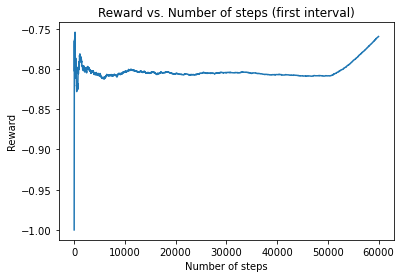

In [28]:
plt.plot(num_step1, current_reward1)
plt.title("Reward vs. Number of steps (first interval)")
plt.xlabel("Number of steps")
plt.ylabel("Reward")

In [15]:
# second interval
second_interval = logs.split("Interval 2 (60000 steps performed)")[1]
lists = re.findall(r".[\d][\.][\d][\d][\d][\d]", second_interval)
current_reward = []
for i in range(len(lists)):
    reward = float(lists[i])
    if reward < -1 or reward > 1:
        current_reward.append(reward * (10 ** (-4)))
    else:
        current_reward.append(reward)

In [16]:
list2 = re.findall(r"......60000", second_interval)
num_step = []
for i in range(len(list2)):
    step = int(list2[i].split("/")[0])
    num_step.append(step)

Text(0, 0.5, 'Reward')

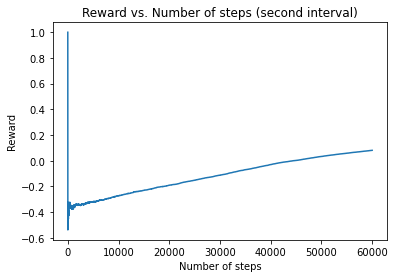

In [29]:
plt.plot(num_step, current_reward)
plt.title("Reward vs. Number of steps (second interval)")
plt.xlabel("Number of steps")
plt.ylabel("Reward")

The plots above show that the model is learning when the number of steps increases. Then we redefine the classify environment using gym with modifications on the step function in order to run test on the model.

In [30]:
# redefine the classify environment using gym with modifications on the step function
class ClassifyEnv(gym.Env):
    def __init__(self, mode, trainx, trainy):  # mode means training or testing
        self.mode = mode

        self.Env_data = trainx
        self.Answer = trainy
        self.id = np.arange(trainx.shape[0])

        self.game_len = self.Env_data.shape[0]

        self.num_classes = len(set(self.Answer))
        self.action_space = spaces.Discrete(self.num_classes)
        print(self.action_space)
        self.step_ind = 0
        self.y_pred = []

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(
        self, a
    ):  # here is the step function which is essential for the agent training
        self.y_pred.append(a)
        y_true_cur = []
        info = {}
        terminal = False
        if a == self.Answer[self.id[self.step_ind]]:
            reward = 1.0
        else:
            reward = -1.0
            if self.mode == "train":
                terminal = True
        self.step_ind += 1

        if self.step_ind == self.game_len - 1:
            y_true_cur = self.Answer[self.id]
            info["gmean"], info["fmeasure"] = self.My_metrics(
                np.array(self.y_pred), np.array(y_true_cur[: self.step_ind])
            )
            terminal = True

        return self.Env_data[self.id[self.step_ind]], reward, terminal, info

    def My_metrics(
        self, y_pre, y_true
    ):  # G-mean score and F_measure are calculated for the testing dataset
        confusion_mat = confusion_matrix(y_true, y_pre)
        print("\n")
        print(classification_report(y_true, y_pre))
        conM = np.array(confusion_mat, dtype="float")
        TP = conM[1][1]
        TN = conM[0][0]
        FN = conM[1][0]
        FP = conM[0][1]
        TPrate = TP / (TP + FN)
        TNrate = TN / (TN + FP)
        FPrate = FP / (TN + FP)
        FNrate = FN / (TP + FN)
        PPvalue = TP / (TP + FP)
        NPvalue = TN / (TN + FN)

        G_mean = np.sqrt(TPrate * TNrate)

        Recall = TPrate = TP / (TP + FN)
        Precision = PPvalue = TP / (TP + FP)
        F_measure = 2 * Recall * Precision / (Recall + Precision)
        print(confusion_mat)
        res = "G-mean:{}, F_measure:{}\n".format(G_mean, F_measure)
        print(res)
        print()
        return G_mean, F_measure

    def reset(self):
        if self.mode == "train":
            np.random.shuffle(self.id)
        self.step_ind = 0
        self.y_pred = []
        return self.Env_data[self.id[self.step_ind]]

In [24]:
# evaluate the dqn model using the test data
env = ClassifyEnv(mode, x_test, y_test)
env.mode = "test"
dqn.test(env, nb_episodes=1, visualize=False)

Discrete(10)
Testing for 1 episodes ...


              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1000
           1       0.71      0.78      0.75      1000
           2       0.48      0.56      0.52      1000
           3       0.51      0.34      0.41      1000
           4       0.56      0.54      0.55      1000
           5       0.64      0.40      0.49      1000
           6       0.56      0.83      0.67      1000
           7       0.69      0.66      0.68       999
           8       0.77      0.73      0.75      1000
           9       0.66      0.73      0.69      1000

    accuracy                           0.62      9999
   macro avg       0.63      0.62      0.62      9999
weighted avg       0.63      0.62      0.62      9999

[[678  21  98  17  25   7  23  12  69  50]
 [ 25 782  20   4  10   3  24   9  25  98]
 [ 57  19 564  50  89  35 107  37  18  24]
 [ 22  44 116 342  94 100 153  51  29  49]
 [ 26  17 105  40 539  29 1

The CIFAR-10 data was able to achieve a G-mean score of 0.97. The model also achieved a 63% accuracy on the testing dataset, which is better than the chance accuracy for this classification problem of 10%. So we can imply that deep q-learning can be a potentially useful approach for image classification tasks.